# JSON To Text

### Pull the required data (Report_ID and PDF content) from a JSON file.

Translate the PDF and text file inside each report. And save it with the name report_ID.txt

In [4]:
import json
import os
import re

# Specify the path to the JSON file
json_path = '02_text_8.json'

# read JSON file
with open(json_path, 'r') as json_file:
    data = json.load(json_file)

# Use regex to get PDF keys dynamically
json_data = []
for report in data:
    pdf_dict = report.get("PDF", {})
    pdf_content = ""
    for key in pdf_dict:
        if re.match(r'^\d+$', key):
            if isinstance(pdf_dict[key], list):
                pdf_content += ' '.join(pdf_dict[key]) + " "
            else:
                pdf_content += pdf_dict[key] + " "

    # Clear Unicode characters, keeping only hyphen (-) and em dash (–) characters
    pdf_content = re.sub(r'[^\x00-\x7F\U00002013\U00002014]+', '', pdf_content)

    json_data.append({
        "Report_ID": report.get("Report_ID", ""),
        "PDF": pdf_content.strip()
    })

# create a folder for reports
folder_name = json_path.split('/')[-1].split('.')[0] + '_reports'
os.makedirs(folder_name, exist_ok=True)

# Create and save a txt file for each report in json_data
for report in json_data:
    report_id = report.get("Report_ID", "")
    pdf_content = report.get("PDF", "")
    txt_file_path = os.path.join(folder_name, f'{report_id}.txt')

    # Create txt file and write into it
    with open(txt_file_path, 'w', encoding='utf-8') as txt_file:
        txt_file.write(pdf_content)

print("All files were created and saved successfully.")


All files were created and saved successfully.


#### Nots:

1. **Key Processing**:
   ```python
   for key in pdf_dict:
       if re.match(r'^\d+$', key):
           if isinstance(pdf_dict[key], list):
               pdf_content += ' '.join(pdf_dict[key]) + " "
           else:
               pdf_content += pdf_dict[key] + " "
   ```
   This snippet checks whether the keys in `pdf_dict` are numbers. Concatenates contents associated with keys that are numbers, so that all PDF contents specified with different numbers are collected correctly.

2. **Unicode Cleanup**:
   ```python
   pdf_content = re.sub(r'[^\x00-\x7F\U00002013\U00002014]+', '', pdf_content)
   ```
   This line strips all characters in `pdf_content` except ASCII characters (U+0000-U+007F) and two special Unicode characters (U+2013 em dash and U+2014 em dash). Thus, only these characters are left in the text and other Unicode characters are removed in the `NER Annotation Tool` to avoid causing character shifting.

In [ ]:
# Save the folder with reports to the desktop
from google.colab import files

!zip -r {folder_name}.zip {folder_name} # Use folder_name for both the zip file and the source folder
files.download(f'{folder_name}.zip')

  adding: 02_text_8_reports/ (stored 0%)
  adding: 02_text_8_reports/16332.txt (deflated 64%)
  adding: 02_text_8_reports/12483.txt (deflated 72%)
  adding: 02_text_8_reports/10965.txt (deflated 62%)
  adding: 02_text_8_reports/12945.txt (deflated 60%)
  adding: 02_text_8_reports/10794.txt (deflated 58%)
  adding: 02_text_8_reports/18027.txt (deflated 67%)
  adding: 02_text_8_reports/16647.txt (deflated 67%)
  adding: 02_text_8_reports/16914.txt (deflated 59%)
  adding: 02_text_8_reports/17582.txt (deflated 65%)
  adding: 02_text_8_reports/17521.txt (deflated 63%)
  adding: 02_text_8_reports/10413.txt (deflated 61%)
  adding: 02_text_8_reports/12185.txt (deflated 64%)
  adding: 02_text_8_reports/18458.txt (deflated 62%)
  adding: 02_text_8_reports/15344.txt (deflated 61%)
  adding: 02_text_8_reports/10245.txt (deflated 68%)
  adding: 02_text_8_reports/17133.txt (deflated 64%)
  adding: 02_text_8_reports/18271.txt (deflated 64%)
  adding: 02_text_8_reports/15059.txt (deflated 14%)
  add

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# NER Annotation with Text

* Label the text in each report_ID.txt with [NER annotation tool](https://tecoholic.github.io/ner-annotator/)

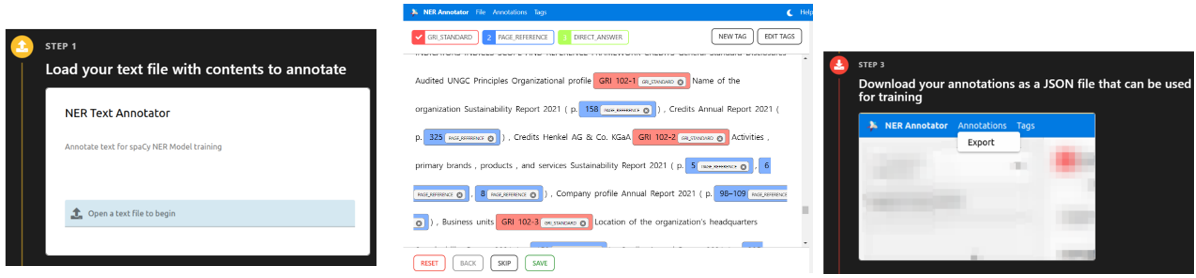

# Text To JSON

* tagged text is saved as annotations.json. **manually** the name is converted to Report_ID_annotations.json.

* An empty folder named xx_text_x_reports_annotations opens. And all Report_ID_annotations.json files obtained from xx_text_x.json are collected in this folder.

# Let's visualize the labels with spacy – displacy

In [ ]:
import spacy
from spacy import displacy

# Install the English model of Spacy
nlp = spacy.load("en_core_web_sm")

# Sample text
text = "Apple is looking at buying U.K. startup for $1 billion"

# Process text
doc = nlp(text)

# NER visualization
displacy.render(doc, style="ent", jupyter=True)


In [ ]:
import json
import spacy
from spacy import displacy

# Load the Spacy model
nlp = spacy.load("en_core_web_sm")

# Specify the path to the JSON file
file_path = "/content/15469_annotations.json"

# Open the JSON file and load the data
with open(file_path, 'r', encoding='utf-8') as file:
    data = json.load(file)

    if 'annotations' in data:
        for annotation in data['annotations']:
            if annotation is not None:
                text = annotation[0]  
                entities = [(ent[0], ent[1], ent[2]) for ent in annotation[1]['entities']]  

                # Prepare the data in the required format for Displacy
                spacy_displacy_data = {
                    "text": text,
                    "ents": [{"start": start, "end": end, "label": label} for start, end, label in entities],
                    "title": None
                }

                # Visualize with Displacy
                displacy.render(spacy_displacy_data, style="ent", manual=True, jupyter=True)


# NER Model Steps

* The data set is created by pulling files named report.json (tagged PDF text files) in the folder named xx_text_x_reports_annotations

# Create Dataset for NER model (with a JSON file)

In [ ]:
import os
import json
import random

# Specify the folder path containing the JSON files
folder_path = '/content/02_text_8_reports_annotations'  

# DATA array (for TRAIN + EVAL)
DATA = []

# Read all JSON files in folder
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            if 'annotations' in data:
                for annotation in data['annotations']:
                    if annotation is not None:
                        text = annotation[0]
                        entities = [(ent[0], ent[1], ent[2]) for ent in annotation[1]['entities']]
                        DATA.append((text, {'entities': entities}))

# Function to clean entities
def clean_entities(text, entities):
    cleaned_entities = []
    for start, end, label in entities:
        # Remove leading and trailing whitespace from the entity span
        while start < len(text) and text[start].isspace():
            start += 1
        while end > 0 and text[end - 1].isspace():
            end -= 1
        if start < end:  # Ensure the span is valid
            cleaned_entities.append((start, end, label))
    return cleaned_entities

# Clean your data
cleaned_data = []
for text, annotations in DATA:
    entities = clean_entities(text, annotations['entities'])
    if entities:  # Only add if there are valid entities
        cleaned_data.append((text, {'entities': entities}))

# shuffle data
random.shuffle(cleaned_data)

# Split the data into 80% Train, 20% Eval
train_size = int(0.8 * len(cleaned_data))
TRAIN_DATA = cleaned_data[:train_size]
EVAL_DATA = cleaned_data[train_size:]

print("Training Data:", len(TRAIN_DATA))
print("Evaluation Data:", len(EVAL_DATA))

Training Data: 8
Evaluation Data: 2


### Let's observe Training Data and Evaluation Data as Dataframe

In [ ]:
# show train data as a df.

import pandas as pd

# Extract text and entities for the DataFrame
train_texts = [item[0] for item in TRAIN_DATA]
train_entities = [item[1]['entities'] for item in TRAIN_DATA]

# Create a DataFrame
df = pd.DataFrame({'Text': train_texts, 'Entities': train_entities})

# Display the DataFrame
df


Text  \
0  1 Sumitomo Chemical CSR Report 2010 Message fr...   
1  K-water 2010 Sustainability Report K-water 201...   
2  HappyLife! HappyEnergy! KDHC Korea District He...   
3  Old Mutual South Africa  Sustainability Report...   
4  2009 Corporate Responsibility Report  2009 Cor...   
5  GRI Report a p p e n d i x T h e  i C a  G r o...   
6  CEO Message 04 About HIRA 06 Governance and Or...   
7  The culture of honesty was spread into teams, ...   

                                            Entities  
0  [(298505, 298509, GRI_STANDARD), (298510, 2985...  
1  [(314926, 314929, GRI_STANDARD), (314983, 3149...  
2  [(226357, 226361, GRI_STANDARD), (226431, 2264...  
3  [(185423, 185426, GRI_STANDARD), (185595, 1855...  
4  [(351704, 351707, GRI_STANDARD), (351734, 3517...  
5  [(1039, 1042, GRI_STANDARD), (1069, 1072, GRI_...  
6  [(152155, 152159, GRI_STANDARD), (152219, 1522...  
7  [(22143, 22146, PAGE_REFERENCE), (22217, 22218...

In [ ]:
# show evaluation data as a df.

import pandas as pd

# Extract text and entities for the DataFrame
eval_texts = [item[0] for item in EVAL_DATA]
eval_entities = [item[1]['entities'] for item in EVAL_DATA]

# Create a DataFrame
df = pd.DataFrame({'Text': eval_texts, 'Entities': eval_entities})

# Display the DataFrame
df


Text  \
0  1                  2011 United Nation Global C...   
1  SUSTAINABILITY  REPORT 2021   03 Foreword  04 ...   

                                            Entities  
0  [(4332, 4335, GRI_STANDARD), (4537, 4542, GRI_...  
1  [(359635, 359644, GRI_STANDARD), (359701, 3597...

# Create NER model

In [ ]:
import os
import json
import spacy
from spacy.training.example import Example
from spacy.util import minibatch, compounding

# Load the pre-trained model
nlp = spacy.blank("en")

# Add the NER pipeline
ner = nlp.add_pipe("ner")

# Add new entity labels
for _, annotations in TRAIN_DATA:
    for ent in annotations.get("entities"):
        ner.add_label(ent[2])

# Disable other pipelines
pipe_exceptions = ["ner"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# Begin training
with nlp.disable_pipes(*unaffected_pipes):
    optimizer = nlp.begin_training()
    for itn in range(100):  # Number of iterations
        losses = {}
        batches = minibatch(TRAIN_DATA, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in zip(texts, annotations)]
            nlp.update(examples, drop=0.5, losses=losses)
        print(f"Iteration {itn}, Losses: {losses}")

# Save the model
nlp.to_disk("custom_ner_model")


/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "1 Sumitomo Chemical CSR Report 2010 Message from C..." with entities "[(298505, 298509, 'GRI_STANDARD'), (298510, 298514...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "Old Mutual South Africa  Sustainability Report 200..." with entities "[(185423, 185426, 'GRI_STANDARD'), (185595, 185596...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be 

Iteration 0, Losses: {'ner': 298509.5949707031}
Iteration 1, Losses: {'ner': 270479.55822753906}
Iteration 2, Losses: {'ner': 232883.78512573242}
Iteration 3, Losses: {'ner': 162611.03161621094}
Iteration 4, Losses: {'ner': 81062.90428161621}
Iteration 5, Losses: {'ner': 16872.12278652191}
Iteration 6, Losses: {'ner': 4279.345818519592}
Iteration 7, Losses: {'ner': 3474.145712852478}
Iteration 8, Losses: {'ner': 3465.3233718425035}
Iteration 9, Losses: {'ner': 3432.199389652349}
Iteration 10, Losses: {'ner': 3412.0432411059737}
Iteration 11, Losses: {'ner': 3326.8119242191315}
Iteration 12, Losses: {'ner': 3422.985260874033}
Iteration 13, Losses: {'ner': 3184.061930179596}
Iteration 14, Losses: {'ner': 3098.8740091323853}
Iteration 15, Losses: {'ner': 3048.1070523262024}
Iteration 16, Losses: {'ner': 2986.7737575769424}
Iteration 17, Losses: {'ner': 2969.492017686367}
Iteration 18, Losses: {'ner': 2789.0382475852966}
Iteration 19, Losses: {'ner': 2693.1472091674805}
Iteration 20, Losse

The `loss` value in the model measures the difference between the outputs predicted by the model and the actual labels. The larger this difference, the greater the `loss` value. The `loss` value indicates the model's error, or how incorrectly it predicts. Therefore, as the 'loss' value decreases during training, it is understood that the model learns better and its predictions are more accurate.

## Various strategies to reduce the loss value during training of the model:

### 1. **Add More Training Data:**
   - **Data Quantity:** Adding more training data can improve the overall performance of the model. Insufficient data can lead to overfitting or underfitting.
   - **Data Diversity:** Diversify your training data. Adding more examples of the same entity types in different contexts and variations can enhance the model's general performance.

### 2. **Reduce Dropout Rate:**
   - The dropout rate (`drop=0.5`) is currently set at 50%. Reducing this rate may allow the model to retain more information. For example, you can change it to `drop=0.3`:
     ```python
     nlp.update(examples, drop=0.3, losses=losses)
     ```

### 3. **Increase the Number of Training Epochs:**
   - You're training for 100 iterations. If your loss value is consistently decreasing, you might consider increasing the number of iterations. However, be cautious as too many iterations can lead to overfitting.

### 4. **Adjust Optimizer Parameters:**
   - You can fine-tune the optimizer initiated with `begin_training()`. For example, adjusting the learning rate could be beneficial. You can add a specific learning rate parameter to the `begin_training()` method:
     ```python
     optimizer = nlp.begin_training(learn_rate=0.001)
     ```

### 5. **Adjust Minibatch Sizes:**
   - Minibatch sizes can be increased or kept constant (e.g., from 4.0 to 32.0). Smaller minibatch sizes may lead to more frequent updates in each iteration, which could improve the learning process:
     ```python
     batches = minibatch(TRAIN_DATA, size=4)
     ```

### 6. **Use Data Augmentation:**
   - To diversify training data, you can use data augmentation techniques. For example, creating different variations by altering words or sentence structures in the training data can be effective.

### 7. **Re-enable Other Pipelines:**
   - If you believe other pipelines besides `ner` could be beneficial, you can re-enable them instead of disabling them. This might help the model learn in a broader context.

By trying one or more of these strategies, you may be able to reduce your model's loss value and improve its overall performance.


## Test NER Model

In [ ]:
import os
import spacy

nlp = spacy.load("custom_ner_model")

sample_report_path = "/content/10701.txt"

with open(sample_report_path, "r") as f:
    sample_text = f.read()

doc = nlp(sample_text)
for ent in doc.ents:
    print(ent.text, ent.label_)


1.1 GRI_STANDARD
8 PAGE_REFERENCE
1.2 GRI_STANDARD
10 PAGE_REFERENCE
2.1 GRI_STANDARD
2.4 GRI_STANDARD
2.6 GRI_STANDARD
2.8 GRI_STANDARD
2.9 GRI_STANDARD
4 PAGE_REFERENCE
2.5 GRI_STANDARD
62 PAGE_REFERENCE
2.7 GRI_STANDARD
16 PAGE_REFERENCE
2.8 GRI_STANDARD
50 PAGE_REFERENCE
2.10 GRI_STANDARD
3.1 GRI_STANDARD
3.4 GRI_STANDARD
3.6 GRI_STANDARD
3.13 GRI_STANDARD
3.5 GRI_STANDARD
10 PAGE_REFERENCE
4.1 GRI_STANDARD
4.7 GRI_STANDARD
4.8 GRI_STANDARD
4.9 GRI_STANDARD
10 PAGE_REFERENCE
4.10 GRI_STANDARD
4.13 GRI_STANDARD
4.14 GRI_STANDARD
4.17 GRI_STANDARD
EC1 GRI_STANDARD
44 PAGE_REFERENCE
EC2 GRI_STANDARD
EC5 GRI_STANDARD
EC9 GRI_STANDARD
EC6 GRI_STANDARD
38 PAGE_REFERENCE
EC7 GRI_STANDARD
62 PAGE_REFERENCE
EC8 GRI_STANDARD
26 PAGE_REFERENCE
44 PAGE_REFERENCE
EN3 GRI_STANDARD
EN9 GRI_STANDARD
EN19 GRI_STANDARD
EN23 GRI_STANDARD
EN24 GRI_STANDARD
EN24 GRI_STANDARD
EN27 GRI_STANDARD
EN1 GRI_STANDARD
EN2 GRI_STANDARD
EN4 GRI_STANDARD
EN5 GRI_STANDARD
EN7 GRI_STANDARD
EN8 GRI_STANDARD
EN10- PAG

# Evaluation of NER model

/usr/local/lib/python3.10/dist-packages/spacy/training/iob_utils.py:149: UserWarning: [W030] Some entities could not be aligned in the text "SUSTAINABILITY  REPORT 2021   03 Foreword  04 Comp..." with entities "[(359635, 359644, 'GRI_STANDARD'), (359701, 359704...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(


Overall Evaluation Scores:
{'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'ents_p': 0.42735042735042733, 'ents_r': 0.16286644951140064, 'ents_f': 0.23584905660377353, 'ents_per_type': {'GRI_STANDARD': {'p': 0.5714285714285714, 'r': 0.0425531914893617, 'f': 0.07920792079207921}, 'PAGE_REFERENCE': {'p': 0.41818181818181815, 'r': 0.215962441314554, 'f': 0.2848297213622291}}, 'speed': 19690.462356603217}

Entity-level Evaluation Scores:
GRI_STANDARD: {'p': 0.5714285714285714, 'r': 0.0425531914893617, 'f': 0.07920792079207921}
PAGE_REFERENCE: {'p': 0.41818181818181815, 'r': 0.215962441314554, 'f': 0.2848297213622291}


<Figure size 1200x600 with 0 Axes>

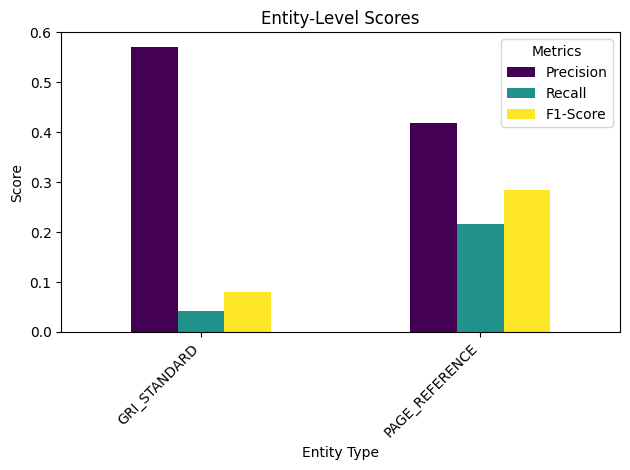

In [ ]:
import spacy
from spacy.training.example import Example
from spacy.util import minibatch, compounding
from spacy.scorer import Scorer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the trained model
nlp = spacy.load("custom_ner_model")

# Set the maximum length for text processing
nlp.max_length = 2000000  # 2 milyon karaktere kadar artırabilirsiniz

# Function to evaluate the model
def evaluate_model(nlp, eval_data):
    scorer = Scorer()
    examples = []
    for text, annotations in eval_data:
        example = Example.from_dict(nlp.make_doc(text), annotations)
        examples.append(example)

    scores = nlp.evaluate(examples)
    return scores

# Function to visualize entity-level scores
def plot_entity_scores(scores):
    # Prepare data for plotting
    ent_types = list(scores["ents_per_type"].keys())
    precision = [scores["ents_per_type"][ent]["p"] for ent in ent_types]
    recall = [scores["ents_per_type"][ent]["r"] for ent in ent_types]
    f1 = [scores["ents_per_type"][ent]["f"] for ent in ent_types]

    df_scores = pd.DataFrame({
        'Entity Type': ent_types,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    })

    # Plot
    plt.figure(figsize=(12, 6))
    df_scores.set_index('Entity Type').plot(kind='bar', colormap='viridis')
    plt.title('Entity-Level Scores')
    plt.xlabel('Entity Type')
    plt.ylabel('Score')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metrics')
    plt.tight_layout()
    plt.show()

# Evaluate the model
scores = evaluate_model(nlp, EVAL_DATA)

# Print evaluation scores
print("Overall Evaluation Scores:")
print(scores)

# Print detailed entity-level scores
print("\nEntity-level Evaluation Scores:")
for ent_type, ent_scores in scores["ents_per_type"].items():
    print(f"{ent_type}: {ent_scores}")

# Plot entity-level scores
plot_entity_scores(scores)


### Overall Evaluation Scores:
- **token_acc**: Tokenization accuracy. A score of 1.0 indicates perfect tokenization.
- **token_p**: Tokenization precision. A score of 1.0 indicates perfect precision.
- **token_r**: Tokenization recall. A score of 1.0 indicates perfect recall.
- **token_f**: Tokenization F1 score. A score of 1.0 indicates a perfect F1 score.
- **ents_p**: Overall precision for entity recognition. A score of 0.5 indicates that 50% of the entities predicted by the model are correct.
- **ents_r**: Overall recall for entity recognition. A score of 1.0 indicates that the model correctly recognized all entities.
- **ents_f**: Overall F1 score for entity recognition. A score of 0.666 indicates a balance between precision and recall.
- **ents_per_type**: Detailed scores for each entity type.

### Entity-level Evaluation Scores:
- **gri_standard**:
  - **p** (precision): 1.0 - The model correctly identified all instances of the `gri_standard` entity type.
  - **r** (recall): 1.0 - The model found all `gri_standard` entities in the evaluation data.
  - **f** (F1 score): 1.0 - The F1 score combines precision and recall into a single metric, and a score of 1.0 indicates perfect performance for this entity type.
- **page_reference**:
  - **p** (precision): 0.0 - The model failed to correctly identify any instances of the `page_reference` entity type.
  - **r** (recall): 0.0 - The model did not find any `page_reference` entities in the evaluation data.
  - **f** (F1 score): 0.0 - The F1 score indicates very poor performance for this entity type.


## Evaluation results evaluation and improvement suggestions:

The model is working, but the results are not ideal. The low overall `ents_f` score (0.2358) indicates that the model is struggling to identify the GRI_STANDARD and PAGE_REFERENCE labels effectively.

### Detailed Results:
- **GRI_STANDARD**:
  - Precision: 0.5714 (High ratio of correct positive predictions)
  - Recall: 0.0426 (Only a small fraction of the correct labels were found)
  - F1-Score: 0.0792 (Low overall performance)
- **PAGE_REFERENCE**:
  - Precision: 0.4182 (Lower ratio of correct positive predictions)
  - Recall: 0.2160 (Approximately 22% of the correct labels were found)
  - F1-Score: 0.2848 (Slightly better overall performance but still low)

### Recommendations:
1. **Data Cleaning and Expansion**: Your data may need further cleaning or enrichment. Increasing the size of your labeled dataset and adding more examples could improve performance.
   
2. **More Training**: Training the model for more iterations, experimenting with different training strategies, or reducing the `dropout` rate could also be beneficial.

3. **Changes in Network Architecture**: Using a different Spacy model (e.g., starting with a pre-trained model) or adjusting the parameters of the `compounding` function (e.g., `size=compounding(4.0, 64.0, 1.001)`) might improve performance.

4. **Data Augmentation**: You can expand your training dataset using data augmentation techniques. For example, adding small text variations or randomizing label placements can enhance your model's overall performance.

After trying these steps, you can reassess your results and observe the progress. These types of fine-tuning are often necessary to improve the model's overall performance.

# Give unlabeled reports to the NER model

* Provide the path to the folder where each report's `pdf content` from a JSON file was previously saved as a `txt` file with the `report_ID` as the filename.

* Print the `report_ID` for each file.

* Pass the `pdf content` from each file to the NER model.

* Print the labeled data for each report.

* Save the `page_reference`, `direct_answer`, and `gri_standard` for later use.

In [4]:
import os
import spacy

# Load the trained model
nlp = spacy.load("custom_ner_model")

# Set the maximum length for text processing
nlp.max_length = 2000000  # 2 milyon karaktere kadar artırabilirsiniz

folder_path = "02_text_8_reports"  # give the folder path consisting of report txt files

# Get the list of files in the folder
files = os.listdir(folder_path)

# Initialize the dictionary to store data
reports_dict = {}

# Apply the NER model to reports in folder
for file in files:
    file_path = os.path.join(folder_path, file)  # Get the full path of the file

    with open(file_path, "r", encoding="utf-8") as f:  # Open the file using the full path
        file_content = f.read()
        doc = nlp(file_content)

        # Temporary lists to store entities for the current report
        page_references = []
        direct_answers = []
        gri_standards = []

        for ent in doc.ents:
            if ent.label_ == 'PAGE_REFERENCE':
                page_references.append(ent.text)
            elif ent.label_ == 'DIRECT_ANSWER':
                direct_answers.append(ent.text)
            elif ent.label_ == 'GRI_STANDARD':
                gri_standards.append(ent.text)

        # Store the entities in the dictionary
        reports_dict[file] = {
            "page_references": page_references,
            "direct_answers": direct_answers,
            "gri_standards": gri_standards
        }

# Print the resulting dictionary
for report_id, content in reports_dict.items():
    print(f"Report ID: {report_id}")
    print(f"Page References: {content['page_references']}")
    print(f"Direct Answers: {content['direct_answers']}")
    print(f"GRI Standards: {content['gri_standards']}")
    print("-" * 50)


Report ID: 10036.txt
Page References: ['6 - 9']
Direct Answers: []
GRI Standards: ['2.1', '2.2', '2.3', '2.4', '2.5', '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '2.1', '2.2', '2.4', '3 (1', '2.5', '3.1', '3.3', '4 (1', '4.11', '3.5', '3.6', 'SO2', '3.17', '3.7', '3.15', '3.17', '3.8']
--------------------------------------------------
Report ID: 10043.txt
Page References: ['15-16', '15-16', '15-16', '14', '15-16', '17-19', '15-16', '17-19', '15', '15-16', '15-16']
Direct Answers: []
GRI Standards: []
--------------------------------------------------
Report ID: 10076.txt
Page References: ['11-2', '11-2', '1-6', '7-9', '1-6', '118-item', '11-2']
Direct Answers: []
GRI Standards: ['SF6', 'SF6', 'FY05', 'SF6']
--------------------------------------------------
Report ID: 10087.txt
Page References: []
Direct Answers: []
GRI Standards: []
--------------------------------------------------
Report ID: 10104.txt
Page References: []
Direct Answers: []
GRI Standards: []
------------

## let's observe report_dict

In [27]:
reports_dict

{'10036.txt': {'page_references': ['6 - 9'],
  'direct_answers': [],
  'gri_standards': ['2.1',
   '2.2',
   '2.3',
   '2.4',
   '2.5',
   '3.1',
   '3.2',
   '3.3',
   '3.4',
   '3.5',
   '3.6',
   '3.7',
   '3.8',
   '2.1',
   '2.2',
   '2.4',
   '3 (1',
   '2.5',
   '3.1',
   '3.3',
   '4 (1',
   '4.11',
   '3.5',
   '3.6',
   'SO2',
   '3.17',
   '3.7',
   '3.15',
   '3.17',
   '3.8']},
 '10043.txt': {'page_references': ['15-16',
   '15-16',
   '15-16',
   '14',
   '15-16',
   '17-19',
   '15-16',
   '17-19',
   '15',
   '15-16',
   '15-16'],
  'direct_answers': [],
  'gri_standards': []},
 '10076.txt': {'page_references': ['11-2',
   '11-2',
   '1-6',
   '7-9',
   '1-6',
   '118-item',
   '11-2'],
  'direct_answers': [],
  'gri_standards': ['SF6', 'SF6', 'FY05', 'SF6']},
 '10087.txt': {'page_references': [],
  'direct_answers': [],
  'gri_standards': []},
 '10104.txt': {'page_references': [],
  'direct_answers': [],
  'gri_standards': []},
 '10135.txt': {'page_references': [],
  '

# Let's apply the functions that edit the page reference and direct response lists

In [7]:
!pip install PyMuPDF

                                              0.0/3.2 MB ? eta -:--:--
                                              0.0/3.2 MB 640.0 kB/s eta 0:00:05
                                              0.1/3.2 MB 518.5 kB/s eta 0:00:07
     -                                        0.1/3.2 MB 837.8 kB/s eta 0:00:04
     -                                        0.1/3.2 MB 847.9 kB/s eta 0:00:04
     -                                        0.1/3.2 MB 847.9 kB/s eta 0:00:04
     ----                                     0.3/3.2 MB 1.2 MB/s eta 0:00:03
     ----                                     0.4/3.2 MB 1.2 MB/s eta 0:00:03
     ----                                     0.4/3.2 MB 1.2 MB/s eta 0:00:03
     ---------                                0.8/3.2 MB 1.8 MB/s eta 0:00:02
     -----------                              1.0/3.2 MB 2.1 MB/s eta 0:00:02
     -----------                              1.0/3.2 MB 2.1 MB/s eta 0:00:02
     ----------------                         1.3/3.2 MB 2.4 

In [32]:
import numpy as np
import re
import fitz  # PyMuPDF


# Helper function to check if a string is a valid number
def is_valid_number(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

# Process direct answers
def process_direct_answers(direct_answers):
    processed_direct_answers = [answer.strip() for answer in direct_answers if answer and answer.strip() and answer != 'NaN']
    
    return processed_direct_answers

# Process page references
def process_page_references(page_refs):
    processed_page_refs = []
    for reference in page_refs:
        reference = reference.replace("~", "-").replace("–", "-").replace("—", "-").strip()
        if '-' in reference:
            parts = reference.split('-')
            if len(parts) == 2 and all(is_valid_number(part) for part in parts):
                start, end = map(int, parts)
                if start <= end:
                    processed_page_refs.extend(range(start, end + 1))
                else:
                    # print(f"The starting number is greater than the ending number: {reference}")
                    pass
            else:
                # print(f"Invalid range format: {reference}")
                pass
        elif is_valid_number(reference):
            processed_page_refs.append(int(reference))
        else:
            #print(f"Invalid reference: {reference}")
            pass
    processed_page_refs = sorted(set(processed_page_refs))
   
    return processed_page_refs


In [79]:
import os
import spacy
import json

# Load the trained model
nlp = spacy.load("custom_ner_model")

# Set the maximum length for text processing
nlp.max_length = 2000000  # Increase up to 2 million characters

folder_path = "02_text_8_reports"  # Folder path consisting of report txt files
output_file = "reports_checkpoint.json"  # File to save progress

# Load checkpoint if it exists
if os.path.exists(output_file):
    with open(output_file, "r", encoding="utf-8") as f:
        reports_dict = json.load(f)
else:
    reports_dict = {}

# Get the list of files in the folder
files = os.listdir(folder_path)

# Apply the NER model to reports in folder
for file in files:
    # Remove .txt extension from the report_id
    report_id = os.path.splitext(file)[0]
    
    # Skip files already processed
    if report_id in reports_dict:
        continue

    file_path = os.path.join(folder_path, file)  # Get the full path of the file

    with open(file_path, "r", encoding="utf-8") as f:  # Open the file using the full path
        file_content = f.read()
        doc = nlp(file_content)

        # Temporary lists to store entities for the current report
        page_references = []
        direct_answers = []
        gri_standards = []

        for ent in doc.ents:
            if ent.label_ == 'PAGE_REFERENCE':
                page_references.append(ent.text)
            elif ent.label_ == 'DIRECT_ANSWER':
                direct_answers.append(ent.text)
            elif ent.label_ == 'GRI_STANDARD':
                gri_standards.append(ent.text)

        # Store the entities in the dictionary
        reports_dict[report_id] = {
            "page_references": process_page_references(page_references),
            "direct_answers": process_direct_answers(direct_answers),
            "gri_standards": gri_standards
        }

        # Save progress after each file
        with open(output_file, "w", encoding="utf-8") as f:
            json.dump(reports_dict, f, ensure_ascii=False, indent=4)

# Print the resulting dictionary
for report_id, content in reports_dict.items():
    print(f"Report ID: {report_id}")
    print(f"Page References: {content['page_references']}")
    print(f"Direct Answers: {content['direct_answers']}")
    print(f"GRI Standards: {content['gri_standards']}")
    print("-" * 50)


Report ID: 10036
Page References: [6, 7, 8, 9]
Direct Answers: []
GRI Standards: ['2.1', '2.2', '2.3', '2.4', '2.5', '3.1', '3.2', '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '2.1', '2.2', '2.4', '3 (1', '2.5', '3.1', '3.3', '4 (1', '4.11', '3.5', '3.6', 'SO2', '3.17', '3.7', '3.15', '3.17', '3.8']
--------------------------------------------------
Report ID: 10043
Page References: [14, 15, 16, 17, 18, 19]
Direct Answers: []
GRI Standards: []
--------------------------------------------------
Report ID: 10076
Page References: [1, 2, 3, 4, 5, 6, 7, 8, 9]
Direct Answers: []
GRI Standards: ['SF6', 'SF6', 'FY05', 'SF6']
--------------------------------------------------
Report ID: 10087
Page References: []
Direct Answers: []
GRI Standards: []
--------------------------------------------------
Report ID: 10104
Page References: []
Direct Answers: []
GRI Standards: []
--------------------------------------------------
Report ID: 10135
Page References: []
Direct Answers: []
GRI Standards: []
---

## let's observe report_dict

In [80]:
reports_dict

{'10036': {'page_references': [6, 7, 8, 9],
  'direct_answers': [],
  'gri_standards': ['2.1',
   '2.2',
   '2.3',
   '2.4',
   '2.5',
   '3.1',
   '3.2',
   '3.3',
   '3.4',
   '3.5',
   '3.6',
   '3.7',
   '3.8',
   '2.1',
   '2.2',
   '2.4',
   '3 (1',
   '2.5',
   '3.1',
   '3.3',
   '4 (1',
   '4.11',
   '3.5',
   '3.6',
   'SO2',
   '3.17',
   '3.7',
   '3.15',
   '3.17',
   '3.8']},
 '10043': {'page_references': [14, 15, 16, 17, 18, 19],
  'direct_answers': [],
  'gri_standards': []},
 '10076': {'page_references': [1, 2, 3, 4, 5, 6, 7, 8, 9],
  'direct_answers': [],
  'gri_standards': ['SF6', 'SF6', 'FY05', 'SF6']},
 '10087': {'page_references': [], 'direct_answers': [], 'gri_standards': []},
 '10104': {'page_references': [], 'direct_answers': [], 'gri_standards': []},
 '10135': {'page_references': [], 'direct_answers': [], 'gri_standards': []},
 '10203': {'page_references': [2,
   4,
   5,
   6,
   7,
   10,
   11,
   14,
   15,
   16,
   17,
   20,
   21,
   22,
   23,
   24,


In [81]:
import json

reports_dict

# Save the reports_dict as a JSON file
with open('reports_dict.json', 'w') as f:
    json.dump(reports_dict, f)

# pdf names and report_ID names will be matched

##### create sample reports_dict (this dictionary was created for testing purposes only and will be removed later)

In [2]:
reports_dict = {
    "350101_2": {"page_references": [6, 7, 8, 9], "direct_answers": [], "gri_standards": ["2.1", "2.2", "2.3", "2.4", "2.5", "3.1", "3.2", "3.3", "3.4", "3.5", "3.6", "3.7", "3.8", "2.1", "2.2", "2.4", "2.5", "3.1", "3.3", "4.11", "3.5", "3.6", "SO2", "3.17", "3.7", "3.15", "3.17", "3.8"]}, 
    
    "350131_1": {"page_references": [14, 15, 16], "direct_answers": [], "gri_standards": ["3.3", "4.11", "3.5", "3.6"]}, 
    
    
    "350191_1": {"page_references": [1, 2, 3, 4], "direct_answers": ["Environmental performance", "Social performance", "Operating performance"], "gri_standards": ["2.1", "2.2", "2.3", "2.4"]},
    

    "350201_1": {"page_references": [], "direct_answers": ["Environmental performance", "Social performance"], "gri_standards": ["SO2", "3.15", "3.17", "3.8"]},
}

# pull relevant pdf's based on matching names and print text according to relevant page_ref in reports_dict

In [3]:
def extract_and_print_pages(pdf_path, page_numbers):
    print("The Texts on PDF's Reference Pages: \n\n")
    pdf_document = fitz.open(pdf_path)
    for page_number in page_numbers:
        actual_page_number = page_number + 2 # +2 meaning: cover page + content table page
        if actual_page_number < 1 or actual_page_number > len(pdf_document):
            print(f"Invalid page number: {page_number}")
            continue
        page = pdf_document.load_page(actual_page_number - 1)
        text = page.get_text()
        print(f"--- Page {page_number} (Real Page {actual_page_number}) ---")
        print(text)
        print("\n" + "="*40 + "\n")
    pdf_document.close()

In [4]:
import os
import fitz  # PyMuPDF

# Path to directory
pdfs_path = 'EN pdfs'

# List to store the names of PDF files
pdf_file_names = []

# List PDF files in directory and save their names
for filename in os.listdir(pdfs_path):
    if filename.endswith('.pdf'):
        filename = filename.replace(".pdf", "").strip()
        pdf_file_names.append(filename)

# Look for matches between keys in reports_dict and names in pdf_file_names
for report_id in reports_dict.keys():
    if report_id in pdf_file_names:
        print(f"Matching name: {report_id}")
        
        # Print if the relevant report has direct_answers
        direct_answers = reports_dict[report_id].get("direct_answers", [])
        if direct_answers:
            print("Direct Answers:")
            for answer in direct_answers:
                print(f"- {answer}")
        
        # If the relevant report has page_references, extract and print the texts
        page_references = reports_dict[report_id].get("page_references", [])
        if page_references:
            pdf_path = os.path.join(pdfs_path, report_id + ".pdf")
            extract_and_print_pages(pdf_path, page_references)


Matching name: 350101_2
The Texts on PDF's Reference Pages: 


--- Page 6 (Real Page 8) ---
0 7  /  W H O  W E  A R E  /   2 0 1 6  I N T E G R AT E D  A N N U A L  R E P O R T
01
+1.9  
million human-hours  
invested in training.
Daily, we give over  
34 thousand children  
in vulnerable situations  
a glass of Lala milk.
We are one of the five  
companies with more  
capital invested in social 
programs in Mexico. 
17 certified 
factories with international 
quality standards. 
$247.6 million pesos invested  
in the renewal of primary  
distribution network and  
delivery units. 
We maintain a rate  
of less than one complaint 
per million pieces. 
RESULTS/
LOGROS
LALA
The reduction from 54.36 to 
36.37 g CO2 eq/kg of product  
in our primary and secondary 
distribution network. 
96% 
of our suppliers  
are of Mexican origin.
Lala and NutriLeche have 
been acknowledged as the 
most chosen brands by  
Mexican consumers.
+540 
thousand people are  
benefited through Lala  
Foundation e

# save outputs

In [5]:
import os
import fitz  # PyMuPDF

# Paths of folders
pdfs_path = 'EN pdfs'
output_folder = 'output_folder'

# Create folder named output_folder
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# List to store the names of PDF files
pdf_file_names = []

# List PDF files in directory and save their names
for filename in os.listdir(pdfs_path):
    if filename.endswith('.pdf'):
        filename = filename.replace(".pdf", "").strip()
        pdf_file_names.append(filename)

# Function that extracts and prints text corresponding to page numbers
def extract_and_print_pages(pdf_path, page_numbers):
    output_text = "The Texts on PDF's Reference Pages: \n\n"
    pdf_document = fitz.open(pdf_path)
    for page_number in page_numbers:
        actual_page_number = page_number + 2  # +2 meaning: cover page + content table page
        if actual_page_number < 1 or actual_page_number > len(pdf_document):
            output_text += f"Invalid page number: {page_number}\n"
            continue
        page = pdf_document.load_page(actual_page_number - 1)
        text = page.get_text()
        output_text += f"--- Page {page_number} (Real Page {actual_page_number}) ---\n"
        output_text += text + "\n"
        output_text += "\n" + "="*40 + "\n"
    pdf_document.close()
    return output_text

# Look for matches between keys in reports_dict and names in pdf_file_names
for report_id in reports_dict.keys():
    if report_id in pdf_file_names:
        output_text = f"Matching name: {report_id}\n"
        
        # Print if the relevant report has direct_answers
        direct_answers = reports_dict[report_id].get("direct_answers", [])
        if direct_answers:
            output_text += "Direct Answers:\n"
            for answer in direct_answers:
                output_text += f"- {answer}\n"
        
        # If the relevant report has page_references, extract and print the texts
        page_references = reports_dict[report_id].get("page_references", [])
        if page_references:
            pdf_path = os.path.join(pdfs_path, report_id + ".pdf")
            output_text += extract_and_print_pages(pdf_path, page_references)
        
        # Save the output to a TXT file
        txt_file_path = os.path.join(output_folder, report_id + ".txt")
        with open(txt_file_path, "w", encoding="utf-8") as txt_file:
            txt_file.write(output_text)
